<a href="https://colab.research.google.com/github/Zain-Haider-ML/SHAP_ALE_Feature_Analysis/blob/main/FuelEfficiency_ML_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

In [2]:
ds = pd.read_csv('/content/fueleconomy.csv', sep = ';')
ds.head()

,Year,Manufacturer,Model,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,...,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,2010,Audi,A6 quattro,14.167143,0,0,0,18,17,0,...,NaN,NaN,0,NaN,2013-01-01,2013-01-01,NaN,0,0,0
1,2010,Cadillac,CTS-V,21.250714,0,0,0,12,0,0,...,NaN,NaN,0,NaN,2013-01-01,2013-01-01,NaN,0,0,0
2,2010,Chevrolet,Malibu,12.935217,3,0,0,19,0,14,...,NaN,NaN,0,NaN,2013-01-01,2019-03-13,NaN,0,0,0
3,2010,Chevrolet,Malibu,11.900400,0,0,0,22,0,0,...,NaN,NaN,0,NaN,2013-01-01,2013-01-01,NaN,0,0,0
4,2010,Kia,Optima,11.900400,0,0,0,22,0,0,...,NaN,NaN,0,NaN,2013-01-01,2013-01-01,NaN,0,0,0


In [3]:
ds.columns

Index(['Year', 'Manufacturer', 'Model', 'barrels08', 'barrelsA08', 'charge120',
       'charge240', 'city08', 'city08U', 'cityA08', 'cityA08U', 'cityCD',
       'cityE', 'cityUF', 'co2', 'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm',
       'comb08', 'comb08U', 'combA08', 'combA08U', 'combE', 'combinedCD',
       'combinedUF', 'cylinders', 'displ', 'drive', 'engId', 'eng_dscr',
       'feScore', 'fuelCost08', 'fuelCostA08', 'fuelType', 'fuelType1',
       'ghgScore', 'ghgScoreA', 'highway08', 'highway08U', 'highwayA08',
       'highwayA08U', 'VClass', 'highwayCD', 'highwayE', 'highwayUF', 'hlv',
       'hpv', 'id', 'lv2', 'lv4', 'mpgData', 'phevBlended', 'pv2', 'pv4',
       'range', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA', 'trany',
       'UCity', 'UCityA', 'UHighway', 'UHighwayA', 'youSaveSpend', 'guzzler',
       'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2', 'rangeA',
       'evMotor', 'mfrCode', 'c240Dscr', 'charge240b', 'c240bDscr',
       'createdOn', 'mo

In [4]:
len(ds)

45896

In [5]:
print(ds.isnull().sum())

Year                0
Manufacturer        0
Model               0
barrels08           0
barrelsA08          0
                ...  
modifiedOn          0
startStop       31689
phevCity            0
phevHwy             0
phevComb            0
Length: 83, dtype: int64


---------------------------

### **Motive**

* Prepare data
* Use for prediction NN and XGBoost
* Make sure that there is no overfitting with test data
* Use SHAP to understand HOW conclusions were
reached
* Use statistical test for correlations
* Use ALE plots for explanation of feature effects

---------------------

Target feature
comb08: Continuous – combined MPG (gasoline-equivalent
miles per gallon) – fuel consumption

In [6]:
ds['comb08']

,comb08
0,21
1,14
2,23
3,25
4,25
...,...
45891,15
45892,16
45893,20
45894,19


* Reduce data to 9 features
* Split data

In [7]:
X = ds[['co2TailpipeGpm','Year','displ','co2','pv4','cylinders','lv4','hlv','ghgScore']]
y = ds['comb08']

X.head()

,co2TailpipeGpm,Year,displ,co2,pv4,cylinders,lv4,hlv,ghgScore
0,423.190476,2010,3.0,-1,98,6.0,16,0,-1
1,634.785714,2010,6.2,-1,100,8.0,16,0,-1
2,386.391304,2010,3.5,-1,95,6.0,16,0,-1
3,355.480000,2010,2.4,-1,95,4.0,16,0,-1
4,355.480000,2010,2.4,-1,104,4.0,14,0,-1


In [8]:
X.shape, y.shape

((45896, 9), (45896,))

In [9]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
co2TailpipeGpm,45896.0,457.657268,128.456466,0.0,382.0,444.35,522.764706,1269.571429
Year,45896.0,2003.608375,12.189427,1984.0,1992.0,2005.00,2015.000000,2023.000000
displ,45411.0,3.281066,1.357082,0.0,2.2,3.00,4.200000,8.400000
co2,45896.0,118.605826,194.017585,-1.0,-1.0,-1.00,307.000000,979.000000
pv4,45896.0,33.228691,45.965271,0.0,0.0,0.00,91.000000,192.000000
cylinders,45409.0,5.710674,1.772177,2.0,4.0,6.00,6.000000,16.000000
lv4,45896.0,5.968995,9.512007,0.0,0.0,0.00,13.000000,55.000000
hlv,45896.0,1.950301,5.893136,0.0,0.0,0.00,0.000000,49.000000
ghgScore,45896.0,0.832012,2.986803,-1.0,-1.0,-1.00,3.000000,10.000000


### Splitting Data for Training & Testing

In [10]:
from sklearn.model_selection import train_test_split

In [19]:
rand = 9

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rand)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand)

In [20]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((31208, 9), (31208,), (7803, 9), (7803,), (6885, 9), (6885,))

In [ ]:
X_train.isnull().sum(), X_val.isnull().sum(), X_test.isnull().sum(), y_train.isnull().sum(), y_val.isnull().sum(), y_test.isnull().sum()

In [22]:
X_train = X_train.fillna(X_train.mean())  # Replace NaNs with mean
y_train = y_train.fillna(y_train.mean())
X_val = X_val.fillna(X_val.mean())
y_val = y_val.fillna(y_val.mean())

X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())

###Training Models: Neural Network

In [15]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=[X_train.shape[1]]))
model.add(tf.keras.layers.Normalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1,))

Adam Optimizer:
* small steps to find global minimum
* large step to pass a local minimum

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005), loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 9)                   │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,772 (10.83 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 19 (80.00 B)

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=200, verbose=1, min_delta=0.0005, restore_best_weights=True)

In [23]:
X_train = pd.DataFrame(X_train)
# X = pd.DataFrame(X)
X_val = pd.DataFrame(X_val)

In [ ]:
model_history = model.fit(X_train.astype(float), y_train.astype(float), epochs=500,
                          validation_data=(X_val.values.astype(float), y_val.values.astype(float)), callbacks=[es],
                          batch_size=64, verbose=2
                          )

In [25]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

In [26]:
# new_model = tf.keras.models.load_model('my_model.keras')

# Show the model architecture
# new_model.summary()

In [ ]:
!pip install plot_keras_history

In [28]:
from plot_keras_history import show_history, plot_history

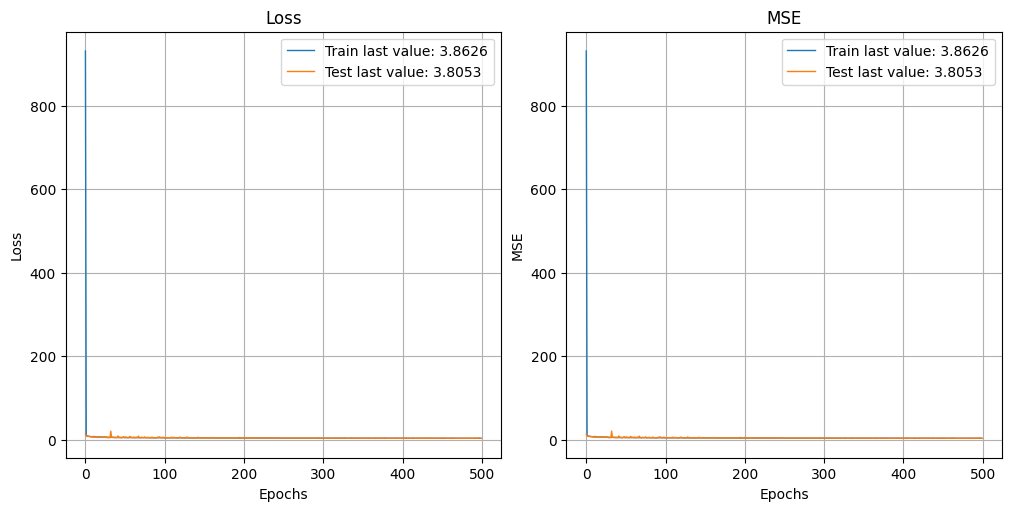

In [29]:
show_history(model_history)

In [30]:
from sklearn import metrics

In [31]:
y_train_pred = model(X_train.astype(float)).numpy()
y_test_pred = model.predict(X_test.astype(float))

RMSE_train = metrics.mean_squared_error(y_train.astype(float), y_train_pred, )
RMSE_test = metrics.mean_squared_error(y_test.astype(float), y_test_pred, )

R2_test = metrics.r2_score(y_test.astype(float), y_test_pred)
# R2_train = metrics.r2_score(y_train, y_train_pred)

print(RMSE_train, RMSE_test, R2_test)

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
3.825126548784564 3.586406607957011 0.9636607509917761


Predicted versus observed miles per gallon (MPG)

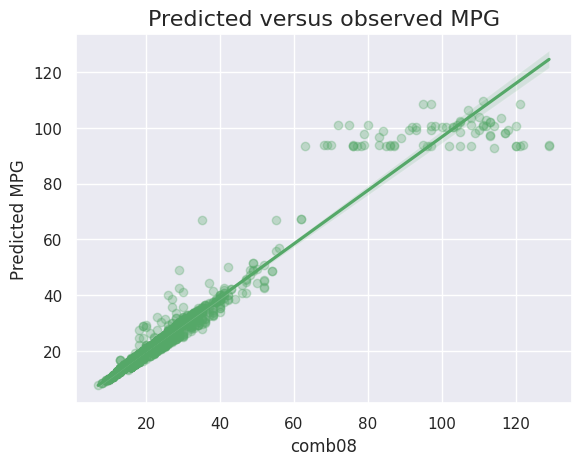

In [32]:
sns.set()
plt.title('Predicted versus observed MPG', fontsize = 16)
plt.xlabel('Observed MPG')
plt.ylabel('Predicted MPG')
sns.regplot(x = y_test, y = y_test_pred, color = 'g', scatter_kws = {'alpha': 0.3})
plt.show()

We know the prediction quality but not
the feature importance

In [ ]:
!pip install xgboost

In [33]:
from xgboost import XGBRegressor
import xgboost as xgb

In [34]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_val = xgb.DMatrix(X_val, label=y_val)
d_test = xgb.DMatrix(X_test, label=y_test)

## One way to use xgb

In [35]:
xgb_model = XGBRegressor(max_depth = 7, learning_rate = 0.6, n_jobs = 4, objective = 'reg:squarederror', random_state = rand, n_estimators = 50)

* n_jobs =4: 4 jobs run in parallel
* n_estimators: number of gradient boosted trees
minimizing the squared error

In [ ]:
fitted_xgb_model_0 = xgb_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], verbose = True,)

Plot history of training and validation data

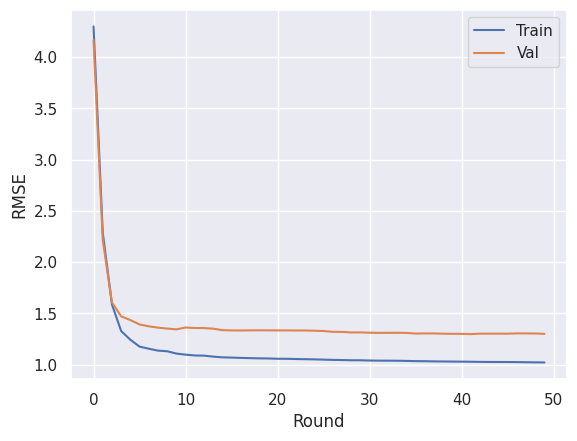

In [37]:
plt.plot(fitted_xgb_model_0.evals_result_['validation_0']['rmse'], label = 'train')
plt.plot(fitted_xgb_model_0.evals_result_['validation_1']['rmse'], label = 'val')
plt.xlabel('Round')
plt.ylabel('RMSE')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

gap between
training and
validation
RMSE :
relatively minor
overfitting

In [38]:
y_train_pred = fitted_xgb_model_0.predict(X_train.astype(float))
y_test_pred = fitted_xgb_model_0.predict(X_test.astype(float))

RMSE_train = metrics.mean_squared_error(y_train.astype(float), y_train_pred, )
RMSE_test = metrics.mean_squared_error(y_test.astype(float), y_test_pred, )

R2_test = metrics.r2_score(y_test.astype(float), y_test_pred)
# R2_train = metrics.r2_score(y_train, y_train_pred)

print(RMSE_train, RMSE_test, R2_test)

1.0440616663095488 37.41100513904998 0.6209331567760203


**Plot feature importance**

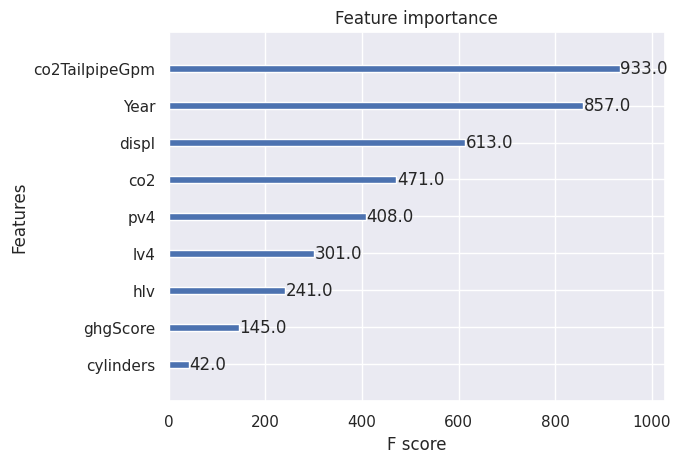

In [39]:
xgb.plot_importance(fitted_xgb_model_0, max_num_features = 12, importance_type='weight')
plt.show()

##2nd way for xgb

In [ ]:
evals = [(d_train, "train"), (d_val, "validation")]

In [ ]:
n = 100
params = {"objective": "reg:squarederror",}

n = 100
fitted_xgb_model = xgb.train(
   params=params,
   dtrain=d_train,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10 # Every ten rounds
)

[0]	train-rmse:7.01111	validation-rmse:6.79371
[10]	train-rmse:1.41303	validation-rmse:1.49339
[20]	train-rmse:1.21034	validation-rmse:1.34378
[30]	train-rmse:1.14821	validation-rmse:1.29926
[40]	train-rmse:1.12392	validation-rmse:1.30334
[50]	train-rmse:1.09819	validation-rmse:1.29398
[60]	train-rmse:1.08311	validation-rmse:1.28152
[70]	train-rmse:1.07328	validation-rmse:1.27800
[80]	train-rmse:1.06603	validation-rmse:1.27445
[90]	train-rmse:1.05961	validation-rmse:1.27209
[99]	train-rmse:1.05348	validation-rmse:1.26746


In [ ]:
xgb_preds = fitted_xgb_model.predict(d_test)

rmse = metrics.mean_squared_error(y_test, xgb_preds,)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 32.996


## SHAP (SHapley Additive exPlanations)

We have illustrative visualization of accuracy
performance of Neural network and feature
importance of Gradient Boosted Tree


But we want to know
HOW conclusions were reached
-> use Shapley values

We have different SHAP Explainer for different
models

In [40]:
import shap

In [41]:
shap_xgb_explainer = shap.TreeExplainer(fitted_xgb_model_0)

Get the SHAP values for train and test data

In [42]:
shap_xgb_values_train = shap_xgb_explainer.shap_values(X_train)
print(shap_xgb_values_train.shape)

shap_xgb_values_test = shap_xgb_explainer.shap_values(X_test)
print(shap_xgb_values_test.shape)

(31208, 9)
(6885, 9)


Plot feature effects of train and test data

negative and positive impact of these
features


amount of dots:
indicates how much a feature impacts the
model negatively (blue) or
positively (red):

negative and positive impact of these features

amount of dots: indicates how much a feature impacts the model negatively (blue) or positively (red)



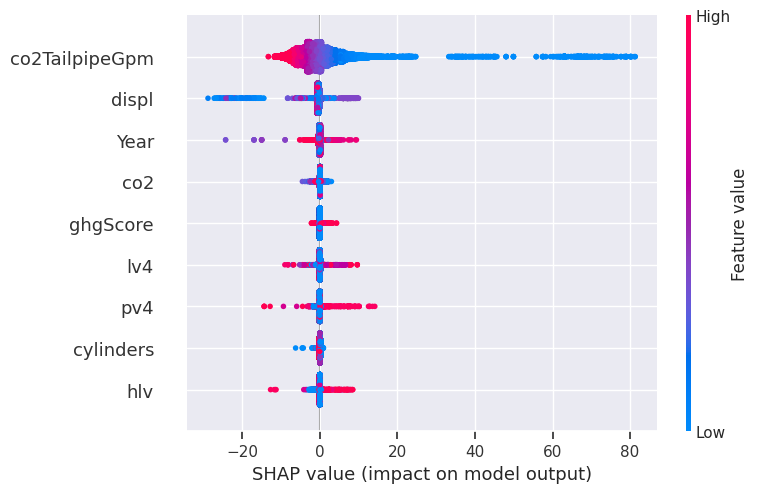

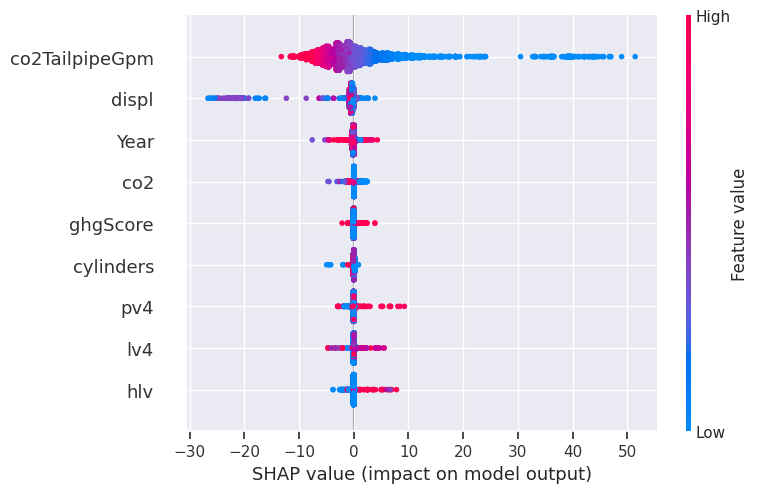

In [43]:
print('negative and positive impact of these features\n')
print('amount of dots: indicates how much a feature impacts the model negatively (blue) or positively (red)\n')

shap.summary_plot(shap_xgb_values_train, X_train, plot_type="dot")
shap.summary_plot(shap_xgb_values_test, X_test, plot_type="dot")

**SHAP GradientExplainer for NN**

In [44]:
background = X_train.iloc[np.random.choice(X_train.shape[0], 150, replace=False)]
print(background.shape)

shap_nn_explainer = shap.GradientExplainer(model,\
background.astype(float).values)

(150, 9)


Compute SHAP values for test data

In [45]:
shap_nn_values_test = shap_nn_explainer.shap_values(X_test.astype(float).values)

print(type(shap_nn_values_test))
print(shap_nn_values_test[0].shape)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(6885, 9))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 9))']
  warnings.warn(msg)


<class 'numpy.ndarray'>
(9, 1)


Generating SHAP summary plots

In [46]:
shap_nn_values_test.shape, X_test.shape, np.squeeze(shap_nn_values_test).shape

((6885, 9, 1), (6885, 9), (6885, 9))

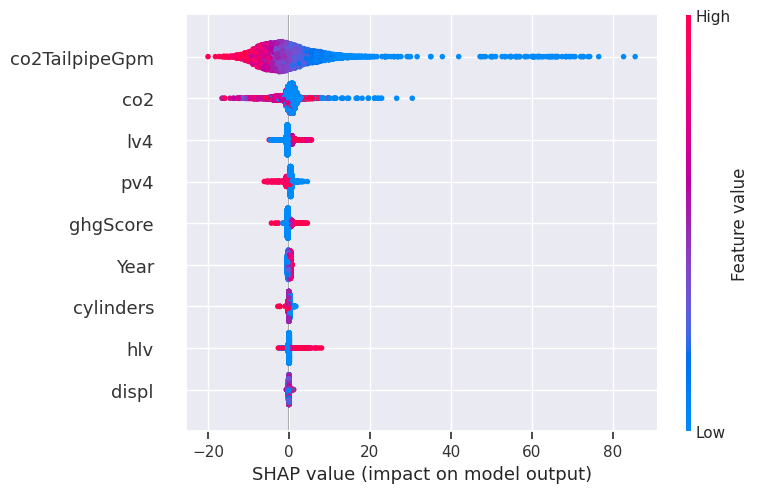

In [47]:
shap.summary_plot(np.squeeze(shap_nn_values_test), X_test, plot_type="dot")

So, the different models have different feature impacts

Feature Impact
NN

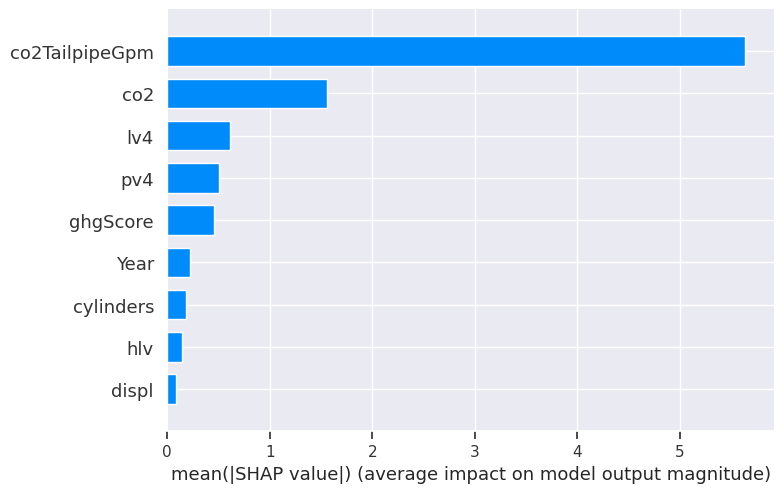

In [48]:
shap.summary_plot(np.squeeze(shap_nn_values_test), X_test, plot_type="bar")

SHAP values used for visualization of
* Feature impact
* Value changes impact


---------------------------------------------------

How can we visualize the interaction between the
features?

Many possible bivariate interactions
between our features

In [50]:
top_features_l = ['comb08'] + ['co2TailpipeGpm',\
'Year','displ','co2','pv4',\
'cylinders','lv4','hlv','ghgScore']

top_df = ds.loc[X_train.index, top_features_l]
top_df

,comb08,co2TailpipeGpm,Year,displ,co2,pv4,cylinders,lv4,hlv,ghgScore
42096,29,306.000000,2018,1.8,306,0,4.0,0,0,6
26913,19,465.000000,2015,4.7,465,0,8.0,0,0,4
5488,25,360.000000,2021,2.5,360,0,4.0,0,0,5
41029,24,374.000000,2022,2.0,374,0,4.0,0,0,5
11892,18,493.722222,1988,2.8,-1,0,6.0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...
14697,16,555.437500,1999,4.0,-1,100,8.0,12,0,-1
5748,104,0.000000,2022,NaN,0,0,NaN,0,24,10
3679,24,376.000000,2018,3.6,376,91,6.0,10,0,5
44503,20,444.350000,2009,3.5,-1,0,6.0,0,0,-1


##Correlation

Visualization using Spearman correlation coefficients

* represented with a heatmap.
* measures the monotonicity (whether the function is increasing or decreasing) between two features.
* Output: between -1 and 1
* direction of the relationship: -/+
* Values closest to both extremes -> strongest,

In [55]:
import scipy

In [51]:
# Reshape y_train to have a second dimension
y_train_reshaped = y_train.values.reshape(-1, 1)

# Calculate correlation coefficients
correlation_matrix = np.corrcoef(X_train.values.astype(float), y_train_reshaped.astype(float), rowvar=False)

# View the correlation matrix
print(correlation_matrix.shape)
y_train_reshaped.shape

(10, 10)


(31208, 1)

triu_indices_from() Return the indices for the upper-triangle of an (n, m) array.

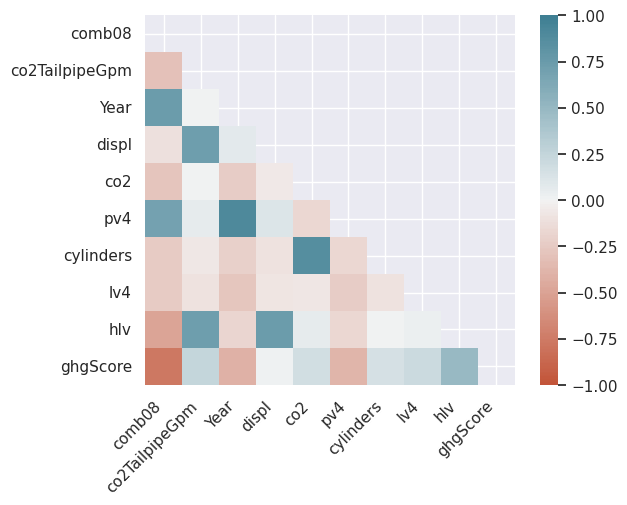

In [52]:
mask = np.zeros_like(correlation_matrix)

mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(
correlation_matrix,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200),
xticklabels=top_df.columns,
yticklabels=top_df.columns,
mask=mask,
square=True
)

ax.set_xticklabels(
ax.get_xticklabels(),
rotation=45,
horizontalalignment='right'
)

plt.show()

Feature Interaction Spearman

In [56]:
# correlation hypothesis test
print('spearman\tco2TailpipeGpm→comb08\tcorr: %.3f\tp-val: %.4f' %
(scipy.stats.spearmanr(X_train.co2TailpipeGpm.values, top_df.comb08.values)))
print('spearman\tco2→comb08\t\tcorr: %.3f\tp-val: %.4f' %
(scipy.stats.spearmanr(X_train.co2.values, top_df.comb08.values)))
print('spearman\tyear→comb08\t\tcorr: %.3f\tp-val: %.4f' %
(scipy.stats.spearmanr(X_train.Year.values, top_df.comb08.values)))
print('spearman\tghgScore→comb08\t\tcorr: %.3f\tp-val: %.4f' %
(scipy.stats.spearmanr(top_df.ghgScore.values, top_df.comb08.values)))
print('spearman\tcylinders→comb08\tcorr: %.3f\tp-val: %.4f' %
(scipy.stats.spearmanr(X_train.cylinders.values, top_df.comb08.values)))
print('spearman\tghgScore→cylinders\t\tcorr: %.3f\tp-val: %.4f' %
(scipy.stats.spearmanr(top_df.ghgScore.values, top_df.cylinders.values)))
print('spearman\tcylinders→co2TailpipeGpm\tcorr: %.3f\tp-val: %.4f' %
(scipy.stats.spearmanr(X_train.cylinders.values, X_train.co2TailpipeGpm.values)))

spearman	co2TailpipeGpm→comb08	corr: -0.993	p-val: 0.0000
spearman	co2→comb08		corr: 0.209	p-val: 0.0000
spearman	year→comb08		corr: 0.269	p-val: 0.0000
spearman	ghgScore→comb08		corr: 0.404	p-val: 0.0000
spearman	cylinders→comb08	corr: -0.775	p-val: 0.0000
spearman	ghgScore→cylinders		corr: nan	p-val: nan
spearman	cylinders→co2TailpipeGpm	corr: 0.778	p-val: 0.0000


-------------------

But how are the
values of the
features correlated?

**SHAP Dependence Plots**

* Plots interaction between two features
* And SHAP value for impact of the prediction

----------------------

SHAP Dependence Plots XGBoost

spearman	co2TailpipeGpm→Year		corr: -0.282	p-val: 0.0000 



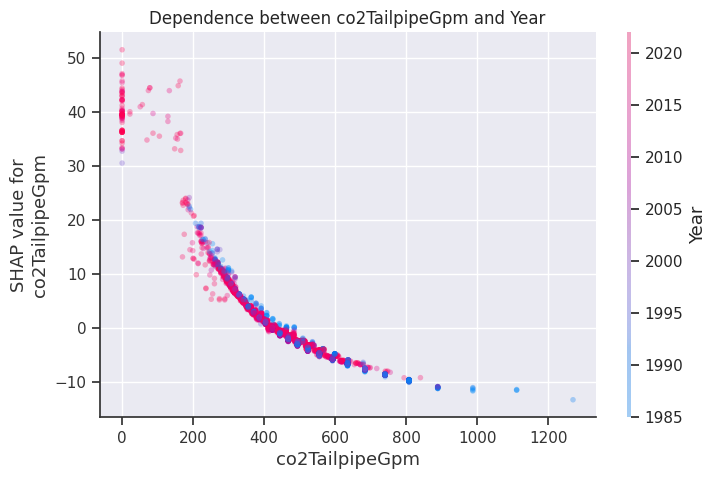

In [57]:
print('spearman\tco2TailpipeGpm→Year\t\tcorr: %.3f\tp-val: %.4f' % (scipy.stats.spearmanr(top_df.co2TailpipeGpm.values, top_df.Year.values)), '\n')

shap.dependence_plot("co2TailpipeGpm", shap_xgb_values_test, X_test, interaction_index="Year", show=False, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.title("Dependence between co2TailpipeGpm and Year")
plt.show()



```
Colors:
- Less co2TailpipeGpm
- Newer cars

Corr: -0.282:
negative correlation between
co2TailpipeGpm → Year
-> negative slope

SHAP value:
- older cars
- more co2TailpipeGpm
- less impact on output
(comb08)
```



spearman\ghgScore→co2		corr: 0.918	p-val: 0.0000 



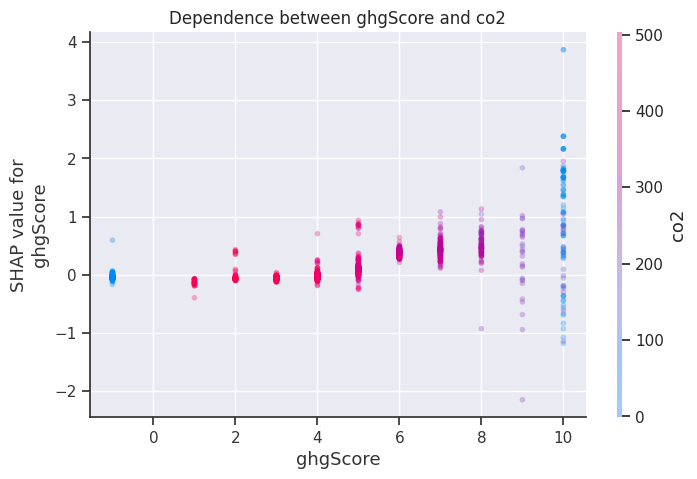

In [58]:
print('spearman\ghgScore→co2\t\tcorr: %.3f\tp-val: %.4f' % (scipy.stats.spearmanr(top_df.ghgScore.values, top_df.co2.values)), '\n')

shap.dependence_plot("ghgScore", shap_xgb_values_test, X_test, interaction_index="co2", show=False, alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.title("Dependence between ghgScore and co2")
plt.show()

you can see that there are some outliers as ghgScore; EPA (Environmental Protection Agency)
score 0((worst))-10 (best), -1: not available


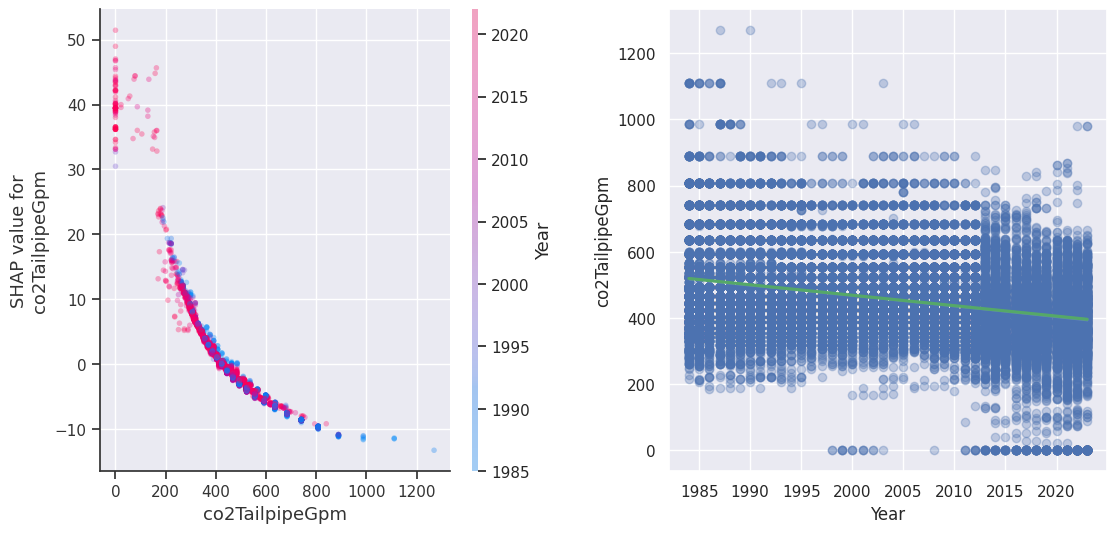

In [59]:
# Set up your figure and axes
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
fig.subplots_adjust(wspace=0.3, hspace=0)

# Plot SHAP dependence plot on the first axis (axs[0])
# To add the SHAP plot into the subplot, you can call the SHAP dependence plot with `ax=axs[0]` argument
shap.dependence_plot("co2TailpipeGpm", shap_xgb_values_test, X_test,
                     interaction_index="Year", show=False, alpha=0.3, ax=axs[0])

# Plot the seaborn regression plot on the second axis (axs[1])
sns.regplot(x=X_train.Year, y=X_train.co2TailpipeGpm, ax=axs[1],
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'g'})

# Show the combined plots
plt.show()

##Accumulated Local Effects (ALE) plots

In [ ]:
!pip install git+https://github.com/blent-ai/ALEPython

In [61]:
from alepython import ale_plot

Plot for 4 top features



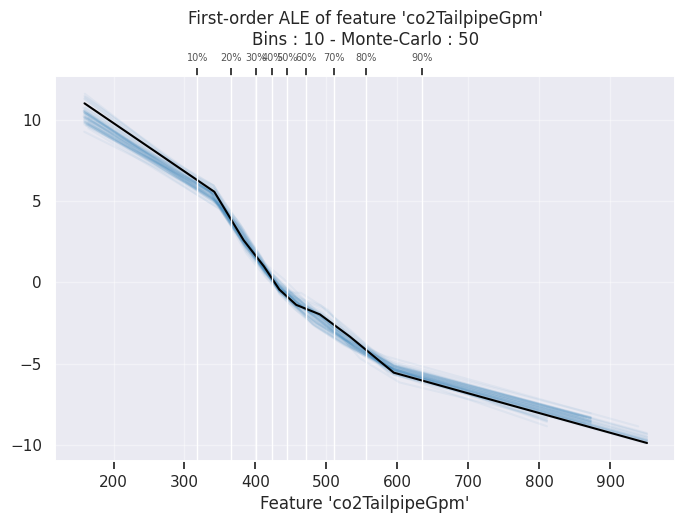

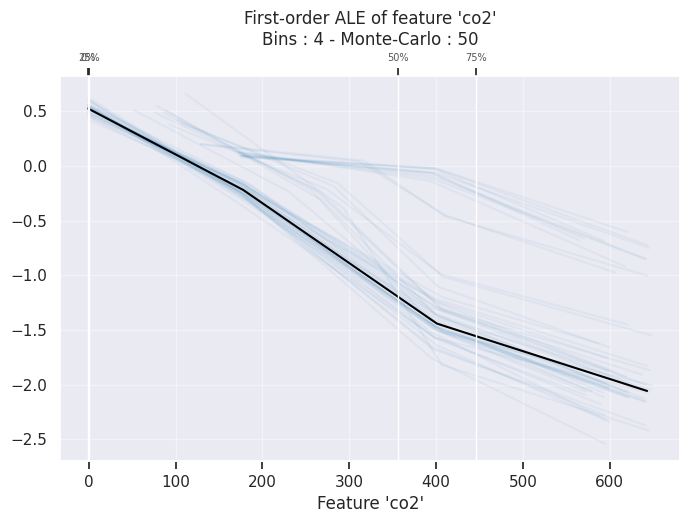

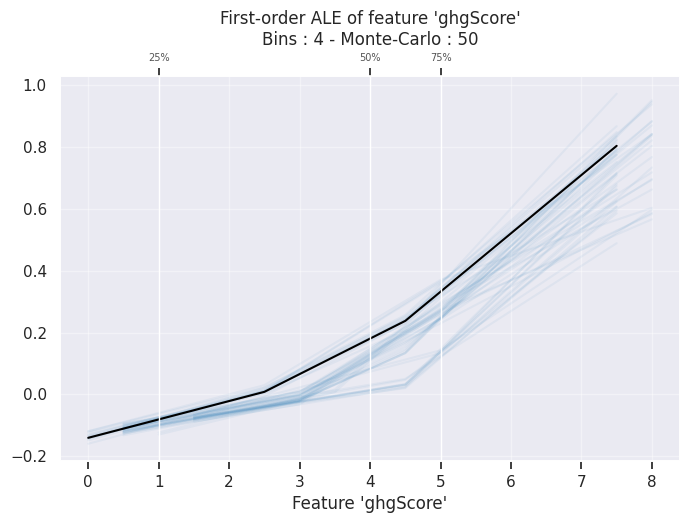

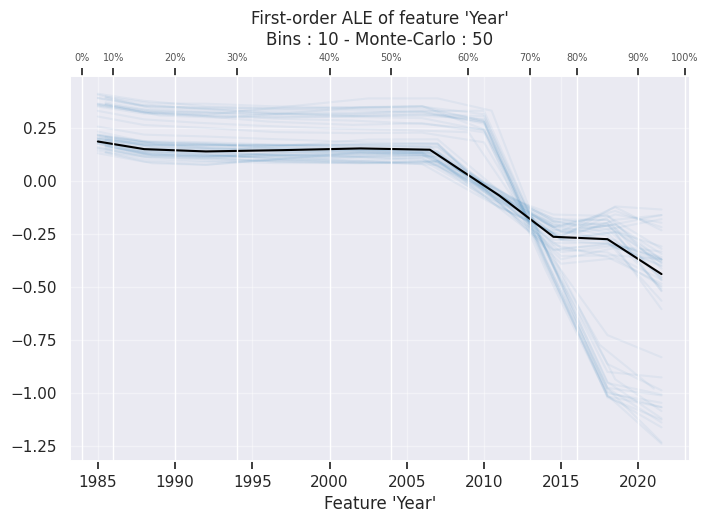

In [62]:
for feature_name in ['co2TailpipeGpm', 'co2','ghgScore','Year']:
  plt.rc("figure", figsize=(8, 5))
  ale_plot(
  xgb_model, X_test, [feature_name],\
  monte_carlo=True, monte_carlo_rep=50,\
  monte_carlo_ratio=0.4
  )
  plt.show()

ALE plots for two features

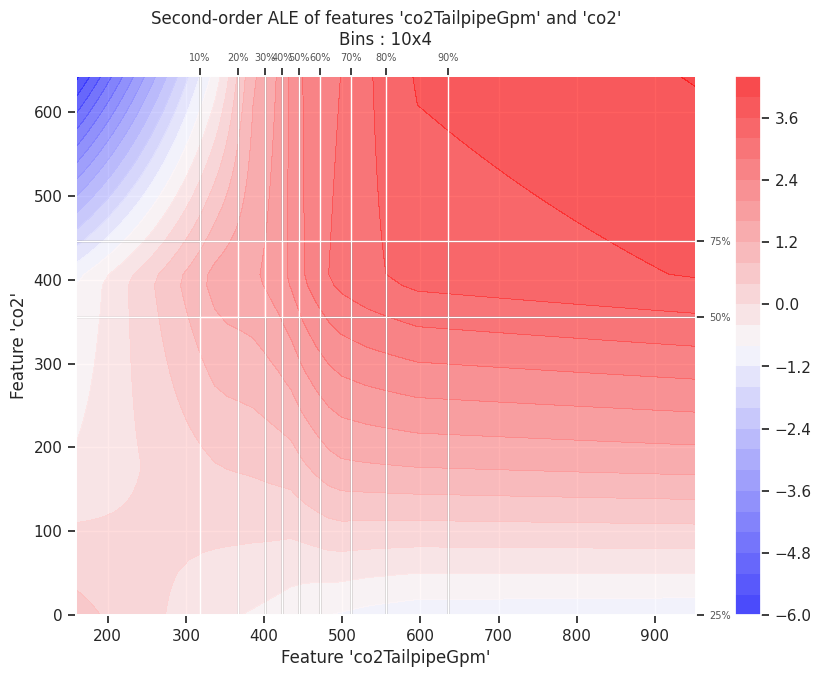

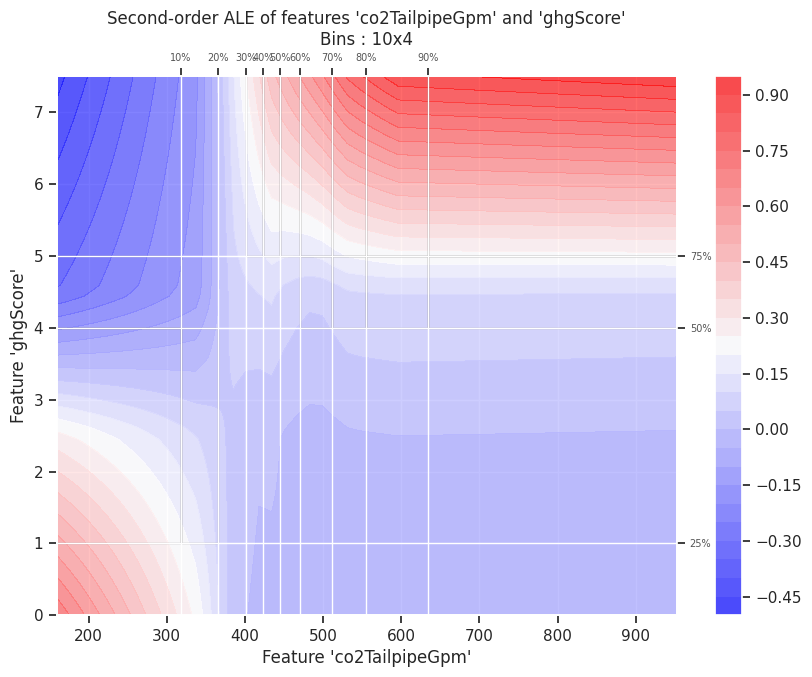

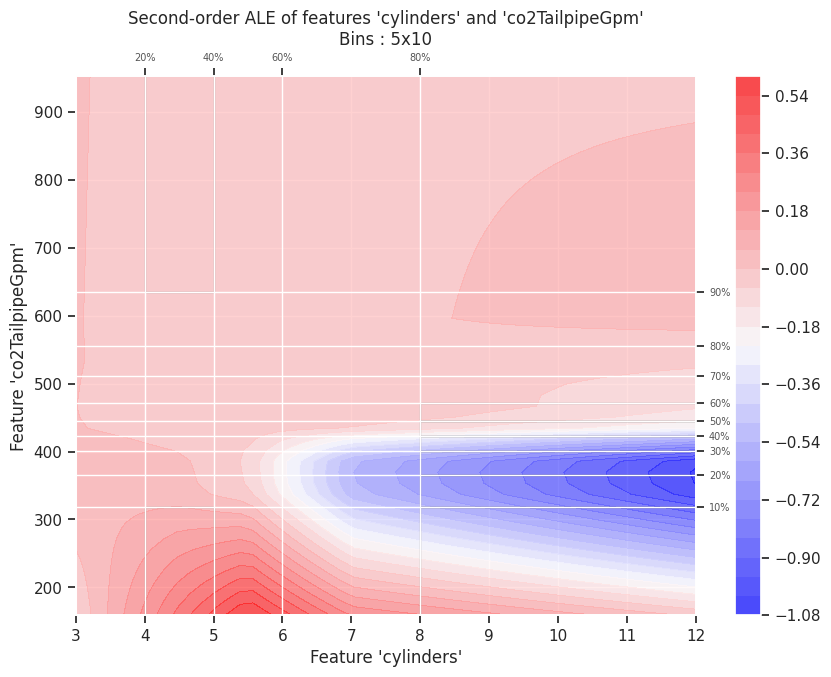

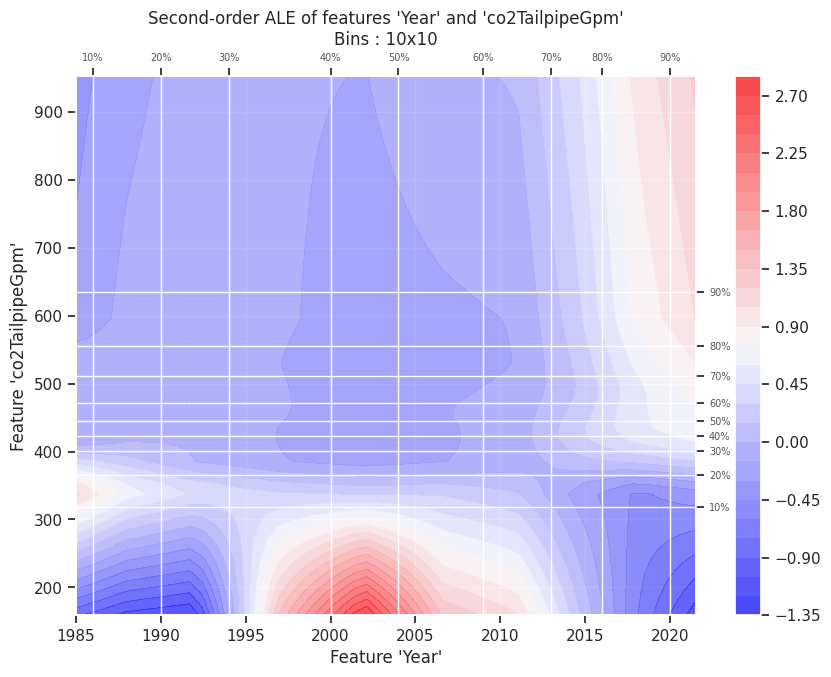

In [63]:
for interaction in [['co2TailpipeGpm','co2'],['co2TailpipeGpm','ghgScore'], ['cylinders', 'co2TailpipeGpm'], ['Year', 'co2TailpipeGpm']]:
  plt.rc("figure", figsize=(10, 7))
  ale_plot(xgb_model, X_test, interaction, bins = [10, 10])

##Surrogates

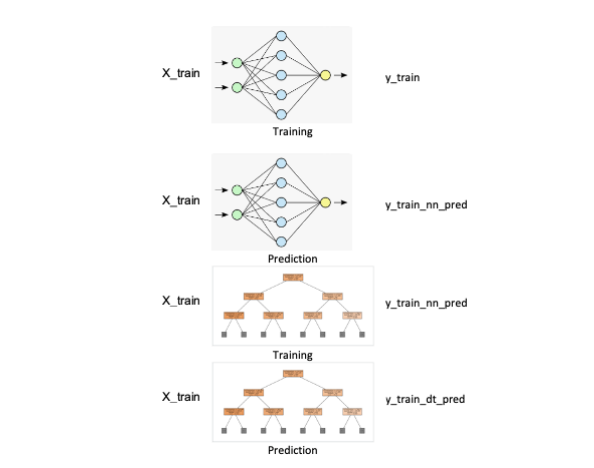

In [64]:
y_train_nn_pred = model(X_train.astype(float))
y_test_nn_pred = model.predict(X_test.astype(float))

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


DecisionTreeRegressor
(as surrogate)

In [65]:
from sklearn import tree

In [66]:
fitted_dt_surrogate = tree.DecisionTreeRegressor(max_depth=7, random_state=rand).fit(X_train, y_train_nn_pred)

In [67]:
y_train_dt_pred = fitted_dt_surrogate.predict(X_train)
y_test_dt_pred = fitted_dt_surrogate.predict(X_test)

Evaluating surrogates
* how well fits each surrogate the neural network model
* how much overfitting is there

In [68]:
#Measure how well Decision Tree replicates Neural Network's predictions

RMSE_dt_nn_train = metrics.mean_squared_error(y_train_nn_pred.numpy(), y_train_dt_pred,)

RMSE_dt_nn_test = metrics.mean_squared_error(y_test_nn_pred, y_test_dt_pred,)

R2_dt_nn_test = metrics.r2_score(y_test_nn_pred, y_test_dt_pred)

#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
(RMSE_dt_nn_train, RMSE_dt_nn_test, R2_dt_nn_test))

RMSE_train: 0.3580	RMSE_test: 0.3578	r2: 0.9962


R2: good (near 1), RMSE_train and RMSE_test: not much different -> no overfitting

**Interpreting surrogates**

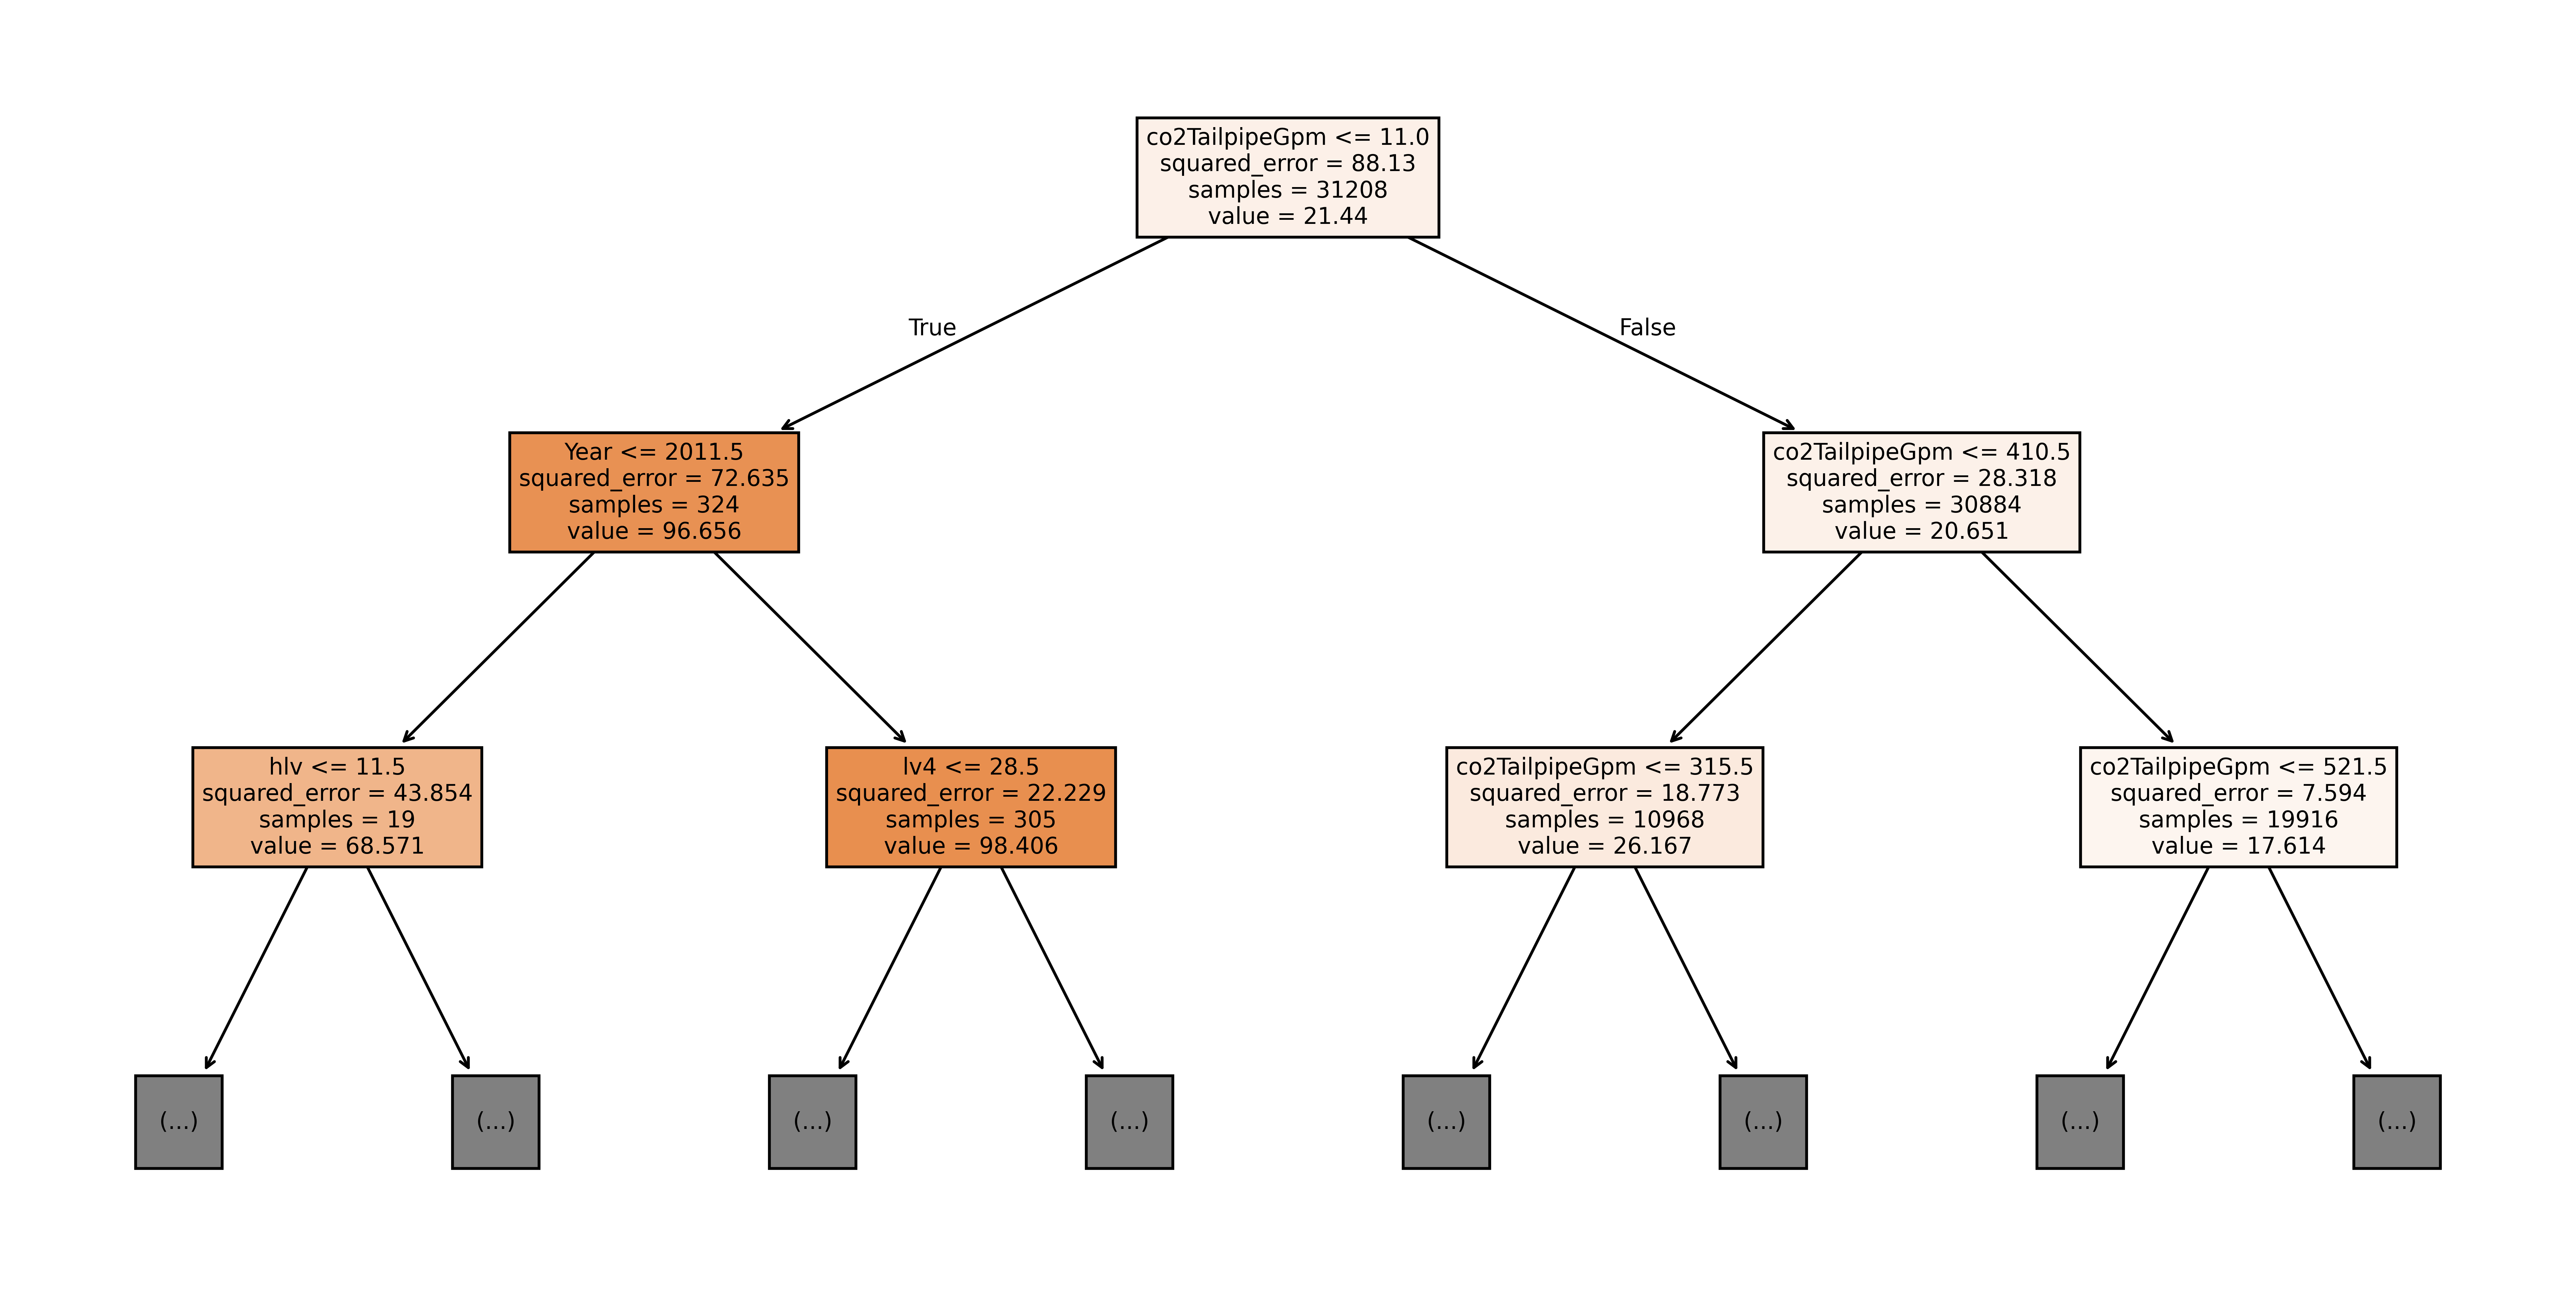

In [69]:
sns.reset_orig()
fig, axes = plt.subplots(nrows = 1, ncols = 1,
figsize = (16,8), dpi=600)
tree.plot_tree(fitted_dt_surrogate,\
feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

**RuleFit**

to get the used rules

In [ ]:
!pip install rulefit
from rulefit import RuleFit # Import the RuleFit class

In [71]:
fitted_rf_surrogate = RuleFit(max_rules=150, rfmode='regress',\
random_state=rand, tree_size=8).\
fit(X_train.astype(float).values,\
np.array(y_train_nn_pred).squeeze(),\
X_train.columns)


In [72]:
y_train_rf_pred = fitted_rf_surrogate.predict(X_train.astype(float).values)
y_test_rf_pred = fitted_rf_surrogate.predict(X_test.astype(float).values)

In [73]:
#Measure how well Rule Fit replicates Neural Network's predictions
RMSE_rf_nn_train = metrics.mean_squared_error(y_train_nn_pred.numpy(),\
y_train_rf_pred,)

RMSE_rf_nn_test = metrics.mean_squared_error(y_test_nn_pred,\
y_test_rf_pred,)

R2_rf_nn_test = metrics.r2_score(y_test_nn_pred, y_test_rf_pred)
#Print all metrics
print('RMSE_train: %.4f\tRMSE_test: %.4f\tr2: %.4f' %\
(RMSE_rf_nn_train, RMSE_rf_nn_test, R2_rf_nn_test))

RMSE_train: 0.6781	RMSE_test: 0.6866	r2: 0.9927


R2: good (near 1), RMSE_train and RMSE_test: not different -> no
overfitting

---------------------

Importance of rules


In [74]:
# Rules
from IPython.display import display
rulefit_df = fitted_rf_surrogate.get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0]
display(rulefit_df.sort_values(by="importance", ascending=False))

,rule,type,coef,support,importance
0,co2TailpipeGpm,linear,-0.033745,1.000000,3.848786
22,co2TailpipeGpm <= 20.0,rule,36.639356,0.008628,3.388632
24,co2TailpipeGpm <= 18.5 & ghgScore > 4.5,rule,14.803414,0.008628,1.369110
19,co2TailpipeGpm <= 11.0 & Year > 2009.5,rule,15.845257,0.006903,1.311893
85,co2TailpipeGpm > 11.0 & co2TailpipeGpm > 395.5,rule,-1.164069,0.722174,0.521418
30,co2TailpipeGpm <= 227.5 & co2TailpipeGpm <= 41...,rule,8.160814,0.002588,0.414658
82,co2TailpipeGpm > 50.5 & co2TailpipeGpm > 413.0,rule,-0.631933,0.627265,0.305560
53,co2TailpipeGpm <= 231.0 & displ > 1.1000000238...,rule,3.122801,0.006903,0.258549
103,co2TailpipeGpm > 337.0 & co2TailpipeGpm > 284....,rule,-0.640769,0.171700,0.241646
104,co2TailpipeGpm > 315.5 & co2TailpipeGpm > 40.5...,rule,-0.533343,0.274374,0.237977
